In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import pandas
from matplotlib import pyplot as plt, rcParams
from matplotlib.colors import LogNorm
from models import Classifier, LegendreLoss, Metrics, find_threshold,DataSet, WeightedMSE, FlatLoss
from models import find_threshold

In [2]:
files = np.load("data/W_FCN_v0.npz")
train = files["train"]
val = files["val"]

maxdata = train.max(axis=0)
mindata = train.min(axis=0)
train = (train-mindata)/(maxdata-mindata)
maxdata = val.max(axis=0)
mindata = val.min(axis=0)
val = (val-mindata)/(maxdata-mindata)

# features = ['mass','pt','tau21', 'c2', 'd2','fw', 
#             'pf','ap','zcutdef','ktdr','sqrtd12','label']
# fig, axes = plt.subplots(3,4,figsize=(12,10))
# for i,ax in enumerate(axes.flatten()):
#     if i==0:
#         ax.set_ylabel('normed counts',fontsize=20)
#     ax.hist(train[:,i][train[:,-1]==0],bins=25,alpha=0.3)
#     ax.hist(train[:,i][train[:,-1]==1],bins=25,alpha=0.3)
#     ax.set_yticks([])
#     ax.set_xlabel(features[i],fontsize=20)
# fig.tight_layout(pad=0)

In [3]:
traindataset = DataSet(samples=train[::,1:-1].astype(float),
                       labels=train[::,-1].astype(int),
                       m = train[::,0].astype(float))
valdataset = DataSet(samples=val[:,1:-1].astype(float),
                     labels=val[:,-1].astype(int),
                    m = val[:,0].astype(float))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('device:', device)

device: cpu


In [4]:
frac=0.93
print("strength",frac/(1-frac))
params = {'epochs'     : 400,
          'interval'   : 100,
          'batch_size' : 2048,
          'shuffle'    : True,
          'num_workers': 6,
          'drop_last'  :True,
          'device'     : device,
          'pass_x_biased':True,
         }

metrics_train_L = Metrics()
metrics_val_L = Metrics(validation=True)
torch.manual_seed(69)
model_L = Classifier().to(device)
optimizer = torch.optim.SGD(model_L.parameters(),lr=1e-1,momentum=0.)
loss =  FlatLoss(labels=traindataset.labels,frac=frac)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
model_L.fit(traindataset=traindataset,
            valdataset=valdataset,
            loss=loss,
            **params,
          #scheduler=scheduler,
          metrics=[metrics_train_L,metrics_val_L])

strength 13.285714285714295
Entering Training...
Epoch:0100/0400 || Train: loss:0.0265, acc:32% || Test: loss: 0.0975, acc:75%, R50: 2.5004, 1/JSD: 13.4122  || 237.8s
Epoch:0200/0400 || Train: loss:0.0279, acc:37% || Test: loss: 0.0975, acc:74%, R50: 3.0899, 1/JSD: 9.6525  || 487.4s
Epoch:0300/0400 || Train: loss:0.0242, acc:45% || Test: loss: 0.0974, acc:74%, R50: 3.7210, 1/JSD: 8.9035  || 742.7s
Epoch:0400/0400 || Train: loss:0.0250, acc:55% || Test: loss: 0.0974, acc:74%, R50: 4.3296, 1/JSD: 8.7687  || 1002.4s


In [5]:
params = {'epochs' : 400,
          'interval'   : 100,
          'batch_size' : 1024,
          'shuffle'    : True,
          'num_workers': 6,
          'pass_x_biased':False
         }
metrics_train = Metrics()
metrics_val = Metrics(validation=True)

In [6]:
torch.manual_seed(69)
model = Classifier()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1,momentum=0.)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
criterion = WeightedMSE(labels=traindataset.labels)
model.fit(traindataset=traindataset,
          valdataset=valdataset,
          **params,
          optimizer= optimizer,
          loss=criterion,
          #scheduler=scheduler,
          metrics=[metrics_train,metrics_val])

Entering Training...
Epoch:0100/0400 || Train: loss:0.1719, acc:83% || Test: loss: 0.0540, acc:84%, R50: 24.3758, 1/JSD: 2.9335  || 386.2s
Epoch:0200/0400 || Train: loss:0.2175, acc:78% || Test: loss: 0.0583, acc:86%, R50: 24.7506, 1/JSD: 3.2407  || 779.9s
Epoch:0300/0400 || Train: loss:0.1718, acc:82% || Test: loss: 0.0542, acc:85%, R50: 25.4826, 1/JSD: 3.1106  || 1174.1s


KeyboardInterrupt: 

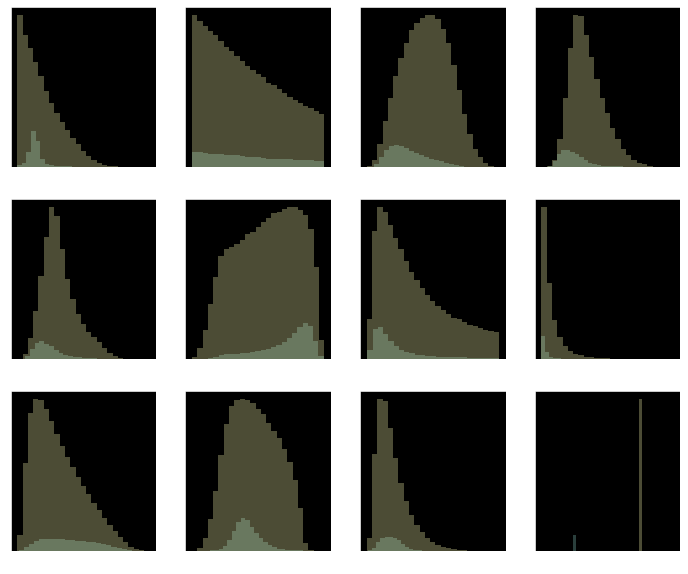

In [7]:
test = files["test"]
metrics_test = Metrics(validation=True)
maxdata = test.max(axis=0)
mindata = test.min(axis=0)
test = (test-mindata)/(maxdata-mindata)

fig, axes = plt.subplots(3,4,figsize=(12,10))
for i,ax in enumerate(axes.flatten()):
    ax.hist(test[:,i][test[:,-1]==0],bins=25,alpha=0.3)
    ax.hist(test[:,i][test[:,-1]==1],bins=25,alpha=0.3)
    ax.set_yticks([])

26.452299975952453


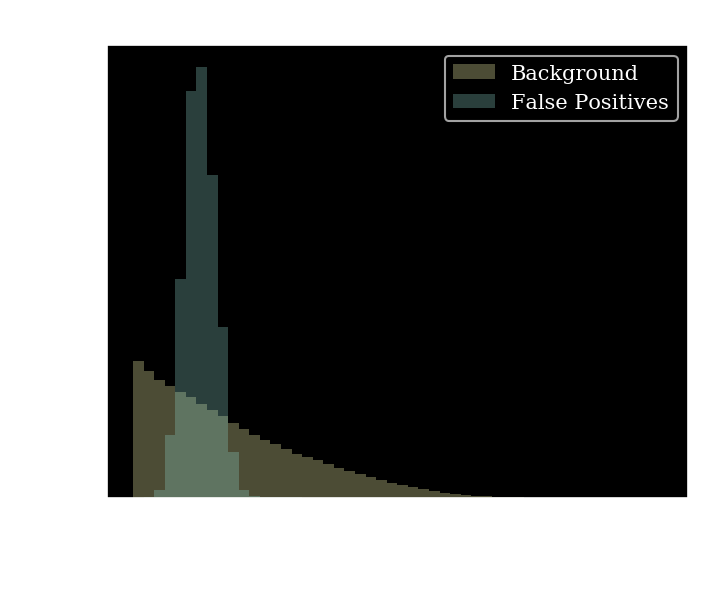

In [32]:
predictions = np.array(model(torch.Tensor(test[:,1:11]).float()).tolist()).flatten()
metrics_test.calculate(pred=predictions, target=test[:,-1])
c = find_threshold(predictions,(test[:,-1]==0),0.5)
R50 = 1/((predictions[test[:,-1]==1]<c).sum()/(test[:,-1]==1).sum())
m =test[:,0]
p, bins = np.histogram(m[test[:,-1]==1],bins=50,density = True)
q, _ = np.histogram(m[(test[:,-1]==1)&(predictions<c)],bins=bins,density = True)
goodidx = (p!=0)&(q!=0)
p = p[goodidx]
q = q[goodidx]
JSD = np.sum(.5*(p*np.log2(p)+q*np.log2(q)-(p+q)*np.log2((p+q)*0.5)))*(bins[1]-bins[0])
print(R50.item())
fig, ax = plt.subplots(1,1,figsize=(5,4),dpi=150)
_,bins,_ = ax.hist(test[:,0][(test[:,-1]==1)],bins=50,alpha=0.3,color='C1',label='Background',density=True)
ax.hist(test[:,0][(test[:,-1]==1)&(predictions<c)],bins=bins,alpha=0.3,color='C0',label='False Positives',density=True)
ax.set_ylabel("Normed Counts",fontsize=20)
ax.set_xlabel(r"$m$",fontsize=20)
plt.title('Naive DNN (R50:{:.2f}, 1/JSD:{:.2f})'.format(R50,1/JSD))
plt.legend()
plt.show()

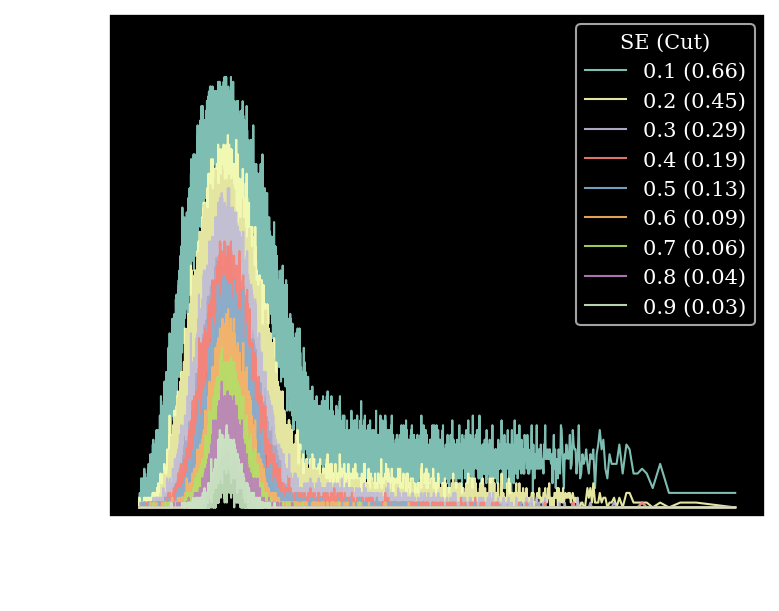

In [29]:
efficiencies = np.linspace(0.1,0.9,9)
cuts = []
for eff in efficiencies:
    cuts.append(find_threshold(predictions,(test[:,-1]==0),eff))


m_t = test[:,0]
sorted_m = np.argsort(m_t)

scores = predictions[sorted_m].reshape(-1,100)

m_t = m_t[sorted_m]
m = m_t.reshape(-1,100).mean(axis=1)
F_s = []
for s in scores.reshape(50,-1):
    density = np.histogram(s,bins=50,range=(0,1))[0]
    F_s.append(np.cumsum(density)/density.sum())
F_s = np.array(F_s).T
fig, ax1 = plt.subplots(1,1,figsize=(5,4),dpi=150)
for j,cut in enumerate(cuts):
    c = f"C{j}" #if j!= 6 else f"C11"
    passed = (scores<cut).sum(axis=1)/scores.shape[1]
    ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)

ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=17)
ax1.set_ylim([-0.02,1.02])
#ax1.set_title("(strength: {:.02f}, acc: {:.02})".format(1, metrics_val_legendre.accs[-1]),fontsize=17)
ax1.legend(loc='upper right', bbox_to_anchor=(1,1) ,markerscale=5,title="SE (Cut)",ncol=1)
ax1.set_xlabel(r"$m$",fontsize=19)

fig.tight_layout(pad=0)
plt.show()

4.419927559109356


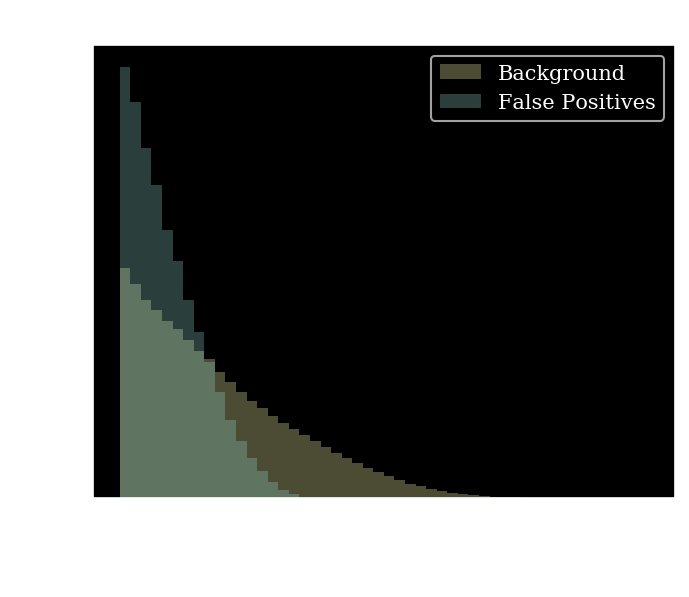

In [30]:
predictions = np.array(model_L(torch.Tensor(test[:,1:11]).float()).tolist()).flatten()
metrics_test.calculate(pred=predictions, target=test[:,-1])
c = find_threshold(predictions,(test[:,-1]==0),0.5)
R50 = 1/((predictions[test[:,-1]==1]<c).sum()/(test[:,-1]==1).sum())
m =test[:,0]
p, bins = np.histogram(m[test[:,-1]==1],bins=50,density = True)
q, _ = np.histogram(m[(test[:,-1]==1)&(predictions<c)],bins=bins,density = True)
goodidx = (p!=0)&(q!=0)
p = p[goodidx]
q = q[goodidx]
JSD = np.sum(.5*(p*np.log2(p)+q*np.log2(q)-(p+q)*np.log2((p+q)*0.5)))*(bins[1]-bins[0])
print(R50.item())
fig, ax = plt.subplots(1,1,figsize=(5,4),dpi=150)
_,bins,_ = ax.hist(test[:,0][(test[:,-1]==1)],bins=50,alpha=0.3,color='C1',label='Background',density=True)
ax.hist(test[:,0][(test[:,-1]==1)&(predictions<c)],bins=bins,alpha=0.3,color='C0',label='False Positives',density=True)
ax.set_ylabel("Normed Counts",fontsize=20)
ax.set_xlabel(r"$m$",fontsize=20)
plt.title('FlatLoss DNN (R50:{:.2f}, 1/JSD:{:.2f})'.format(R50,1/JSD))
plt.legend()
plt.show()

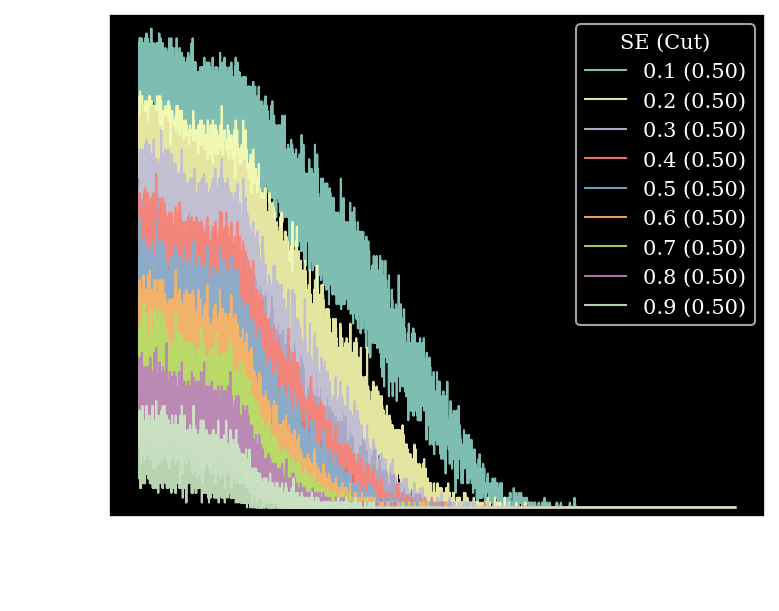

In [31]:
efficiencies = np.linspace(0.1,0.9,9)
cuts = []
for eff in efficiencies:
    cuts.append(find_threshold(predictions,(test[:,-1]==0),eff))


m_t = test[:,0]
sorted_m = np.argsort(m_t)

scores = predictions[sorted_m].reshape(-1,100)

m_t = m_t[sorted_m]
m = m_t.reshape(-1,100).mean(axis=1)
F_s = []
for s in scores.reshape(50,-1):
    density = np.histogram(s,bins=50,range=(0,1))[0]
    F_s.append(np.cumsum(density)/density.sum())
F_s = np.array(F_s).T
fig, ax1 = plt.subplots(1,1,figsize=(5,4),dpi=150)
for j,cut in enumerate(cuts):
    c = f"C{j}" #if j!= 6 else f"C11"
    passed = (scores<cut).sum(axis=1)/scores.shape[1]
    ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)

ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=17)
ax1.set_ylim([-0.02,1.02])
#ax1.set_title("(strength: {:.02f}, acc: {:.02})".format(1, metrics_val_legendre.accs[-1]),fontsize=17)
ax1.legend(loc='upper right', bbox_to_anchor=(1,1) ,markerscale=5,title="SE (Cut)",ncol=1)
ax1.set_xlabel(r"$m$",fontsize=19)

fig.tight_layout(pad=0)
plt.show()